# TestCase3 - Comparaison gains PINNs/PINNs+Corr et FEM/PINNs+Corr

In [47]:
# sélection du cas test
testcase = 3
size_param = "big"
largenet = False
degree = 2
n_params = 50

In [48]:
assert testcase == 3
assert size_param in ["small","medium","big"]

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les gains obtenues pour

- PINNs vs PINNs + Correction par addition
- FEM vs PINNs + Correction par addition

On choisira d'effectuer ces comparaisons sur 2 tailles de grilles fixées (20x20 et 40x40) en sélectionnant 50 paramètres aléatoires.

## Imports + Load

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

# from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from modules.utils import create_tree
from modules.geometry import Square
from modules.fenics_expressions_3 import FExpr,AnisotropyExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
from modules.testcases.d2.test_3.test_3_v1 import Run_laplacian2D,Poisson_2D
from modules.problem import TestCase3,TestCase3_small_param,TestCase3_medium_param
from modules.solver_fem_3 import FEMSolver
    
if size_param == "big":
    problem = TestCase3()
elif size_param == "medium":
    problem = TestCase3_medium_param()
else:
    problem = TestCase3_small_param()

dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/"+size_param
if size_param == "medium" and largenet:
    result_dir += "_largenet"
result_dir += "/facteurs/"
create_tree(result_dir)

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

hmax =  0.07443229275647877
hmax =  0.036261886214694776


>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe3.pth
network loaded


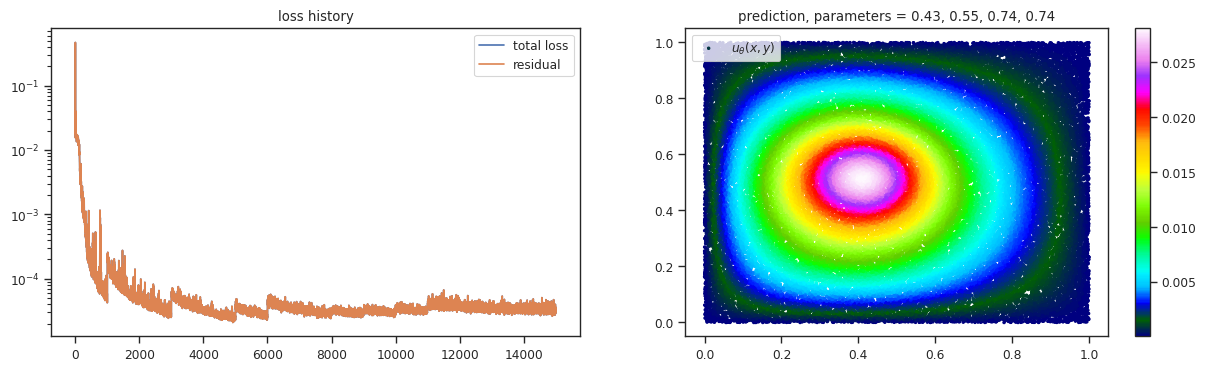

In [52]:
pde = Poisson_2D(size_param)
trainer,u_theta = Run_laplacian2D(pde,size_param,largenet)

In [53]:
def get_params(n_params):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    params = []
    for j in range(n_params):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
        params.append(param)
    # params = np.round(params, 2)
    return np.array(params)

params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)},{params[i][2].round(2)},{params[i][3].round(2)}" for i in range(n_params)])

## Solution de référence

In [54]:
def create_ref_domain(deg):
    nb_vert = 500

    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Square):
        box = np.array(problem.geometry.box)
        mesh_ref = df.RectangleMesh(df.Point(box[0,0], box[1,0]), df.Point(box[0,1], box[1,1]), nb_vert - 1, nb_vert - 1)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref
    
def get_uref(param, mesh_ref, V_ref, dx_ref):
    
    boundary = "on_boundary"

    mat = AnisotropyExpr(param, degree=10, domain=mesh_ref, pb_considered=problem) 
    # mat = df.Expression((("eps * x[0]*x[0] + x[1]*x[1]","(eps - 1) * x[0] * x[1]"),
    #                 ("(eps - 1) * x[0] * x[1]","x[0]*x[0] + eps * x[1]*x[1]")), 
    #                 eps=param[3],
    #                 degree=10, 
    #                 domain=mesh_ref)
    
    f_expr = FExpr(param, degree=10, domain=mesh_ref, pb_considered=problem)
    
    g = df.Constant("0.0")
    bc = df.DirichletBC(V_ref, g, boundary)

    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(mat*df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    sol = df.Function(V_ref)
    df.solve(a==l, sol, bcs=bc)

    return sol

mesh_ref, V_ref, dx_ref = create_ref_domain(deg=2)


hmax =  0.002834095315376947


In [55]:
loadresult = True

savedir = result_dir + "u_ref/"
create_tree(savedir)

tab_u_ref = []
if not loadresult:
    for i,param in enumerate(params):
        print(i, param)
        filename = savedir + f"u_ref_{i}.npy"
        u_ref = get_uref(param, mesh_ref, V_ref, dx_ref)
        vct_u_ref = u_ref.vector().get_local()
        np.save(filename, vct_u_ref)
        tab_u_ref.append(u_ref)
else:
    for i,param in enumerate(params):
        filename = savedir + f"u_ref_{i}.npy"
        if os.path.exists(filename):
            vct_u_ref = np.load(filename)
            u_ref = df.Function(V_ref)
            u_ref.vector()[:] = vct_u_ref
            tab_u_ref.append(u_ref)
        else:
            print(i, param)
            u_ref = get_uref(param, mesh_ref, V_ref, dx_ref)
            vct_u_ref = u_ref.vector().get_local()
            np.save(filename, vct_u_ref)
            tab_u_ref.append(u_ref)
            

## Erreurs FEM

In [56]:
def read_csv_FEM(testcase,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_degree{degree}.csv')
    tab_err_FEM = df_FEM.values[2:,1:]
    return tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_degree{degree}.csv'
    col_names = [("FEM",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_FEM = read_csv_FEM(testcase,degree)
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_FEM = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                _,norme_L2 = solver.fem(i,tab_u_ref[i])
                tab_err_FEM[i,j] = norme_L2
            print()
        
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        df_FEM.to_csv(csv_file)
           
    return df_FEM, tab_err_FEM

In [57]:
df_FEM, tab_err_FEM = run_FEM(degree,new_run=True)

nb_vert=20
hmax =  0.07443229275647877
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.036261886214694776
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Erreurs PINNs

In [58]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [59]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()

                uref_Vex = df.interpolate(tab_u_ref[i],solver.V_ex)
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

In [60]:
df_PINNs, tab_err_PINNs = run_PINNs(degree,new_run=True)

nb_vert=20
hmax =  0.07443229275647877
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.036261886214694776
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Erreurs Corr

In [61]:
def read_csv_Corr(testcase,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_degree{degree}.csv')
    tab_err_Corr = df_Corr.values[2:,1:]
    
    return tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_degree{degree}.csv'
    col_names = [("Corr",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_Corr = read_csv_Corr(testcase,degree)
        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_Corr = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_Corr = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_Corr)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()
                
                _,_,norme_L2 = solver.corr_add(i,u_PINNs,tab_u_ref[i])
                tab_err_Corr[i,j] = norme_L2
            print()

        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        df_Corr.to_csv(csv_file)
        
    return df_Corr, tab_err_Corr

In [62]:
df_Corr, tab_err_Corr = run_Corr(degree)

nb_vert=20
hmax =  0.07443229275647877
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
nb_vert=40
hmax =  0.036261886214694776
param = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


## Dataframe erreurs

In [63]:
# concatenate dataframe : for each columns, we have the error for each method
# we want a multiindex dataframe with FEM, PINNs and Corr for each n_vert and h
col_names = [("FEM",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("PINNs",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Corr",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))]

mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
row_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df = pd.DataFrame(columns=mi,index=row_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j]] = tab_err_FEM[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j2+j]] = tab_err_PINNs[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j3+j]] = tab_err_Corr[i,j]
        
df.to_csv(result_dir+f'comparison_case{testcase}_degree{degree}.csv')

## Dataframe facteurs

In [64]:
facteurs_PINNs_Corr = df["PINNs"] / df["Corr"]
facteurs_FEM_PINNs = df["FEM"] / df["PINNs"]
facteurs_FEM_Corr = df["FEM"] / df["Corr"]

col_names = [("FEM/PINNs",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))]
mi = pd.MultiIndex.from_tuples(col_names, names=["facteurs","n_vert","h"])

index_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df_facteurs = pd.DataFrame(columns=mi,index=index_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j]] = facteurs_FEM_PINNs.to_numpy()[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j2+j]] = facteurs_PINNs_Corr.to_numpy()[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j3+j]] = facteurs_FEM_Corr.to_numpy()[i,j]
        
df_facteurs.to_csv(result_dir+f'comparison_facteurs_case{testcase}_degree{degree}.csv')


## Boxplots

In [65]:
sns.set_style('darkgrid')
sns.set_theme(style="ticks")
sns.set_context("paper")
    
def plot_boxplot(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]

    sns.boxplot(data=df_facteurs_n_vert, orient="h", palette="Set2")
    plt.grid(axis="x", visible=True, which="both")
    plt.title(f"n_vert={n_vert}, n_params={n_params}")
    
    return df_facteurs_n_vert

def plot_table(df_facteurs_n_vert,ax):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    
    df_val = pd.concat([df_min,df_max,df_mean],axis=1).T
    tab = df_val.values.T.astype(float)
    tab = np.round(tab,2)

    thetable = ax.table(cellText=tab, rowLabels=df_facteurs_n_vert.columns, colLabels=["min","max","mean"], loc='right', cellLoc='center', colLoc='center', bbox=[0,0,1,1])
    thetable.scale(1.,0.8)
    thetable.auto_set_font_size(False)
    
    ax.axis('off')

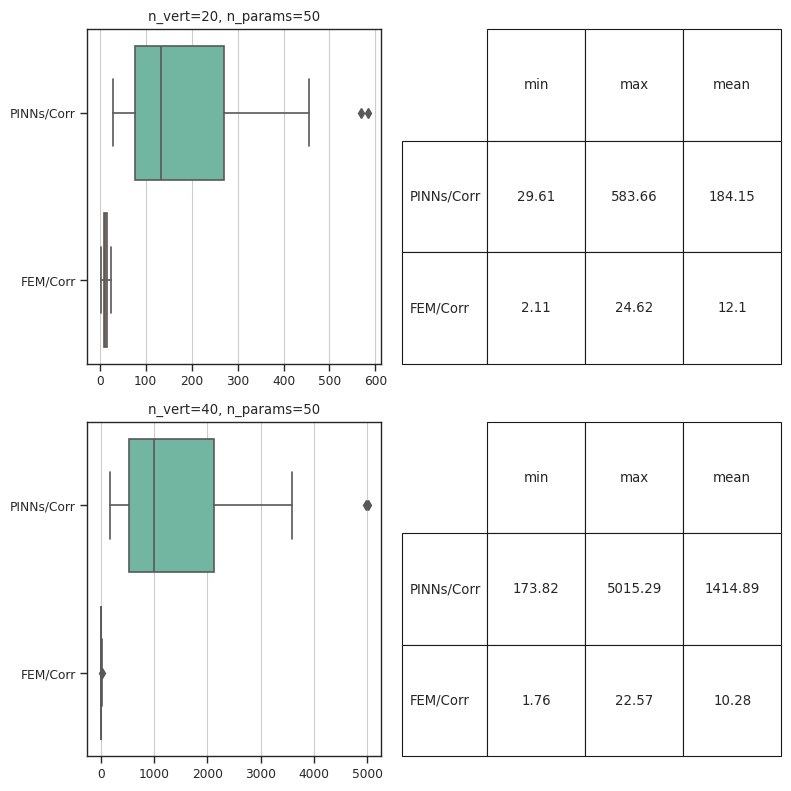

In [66]:
nb_test = len(tab_nb_vert)

plt.figure(figsize=(8,nb_test*4))

for i in range(nb_test):
    plt.subplot(nb_test,2,2*i+1)
    df_facteurs_n_vert = plot_boxplot(i)

    ax = plt.subplot(nb_test,2,2*i+2)
    plot_table(df_facteurs_n_vert,ax)

plt.tight_layout()
plt.savefig(result_dir+f'boxplot_facteurs_case{testcase}_degree{degree}.png')
plt.show()

## Table

In [67]:
def get_df_facteurs_n_vert(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]
    
    return df_facteurs_n_vert

def get_values(df_facteurs_n_vert):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    df_std = df_facteurs_n_vert.std(axis=0)
    
    return [df_min["PINNs/Corr"],df_max["PINNs/Corr"],df_mean["PINNs/Corr"],df_std["PINNs/Corr"]], \
            [df_min["FEM/Corr"],df_max["FEM/Corr"],df_mean["FEM/Corr"],df_std["FEM/Corr"]]

In [68]:
nb_test = len(tab_nb_vert)

tab_gains_on_PINNs = []
tab_gains_on_FEM = []

for i in range(nb_test):
    df_facteurs_n_vert = get_df_facteurs_n_vert(i)
    gains_on_PINNs,gains_on_FEM = get_values(df_facteurs_n_vert)
    tab_gains_on_PINNs.append(gains_on_PINNs)
    tab_gains_on_FEM.append(gains_on_FEM)
    
tab_gains_on_PINNs = np.array(tab_gains_on_PINNs)
tab_gains_on_FEM = np.array(tab_gains_on_FEM)

columns= ["N","min_PINNs","max_PINNs","mean_PINNs","std_PINNs","min_FEM","max_FEM","mean_FEM","std_FEM"]

df_gains = pd.DataFrame(np.concatenate([np.array(tab_nb_vert).reshape(-1,1),tab_gains_on_PINNs,tab_gains_on_FEM],axis=1),columns=columns)

In [69]:
df_gains

,N,min_PINNs,max_PINNs,mean_PINNs,std_PINNs,min_FEM,max_FEM,mean_FEM,std_FEM
0,20.0,29.606325,583.663750,184.151886,137.619321,2.108400,24.623544,12.096587,5.962015
1,40.0,173.824294,5015.291027,1414.894178,1174.995015,1.763961,22.566203,10.278489,5.929664


In [70]:
result_file = result_dir+f'gains_table_case{testcase}_degree{degree}'

df_gains.to_csv(result_file+'.csv')

df_styled = df_gains.style.format("{:.2e}")
dfi.export(df_styled,result_file+".png",dpi=1000)